# VCA for antiferromagnetism

Find the VCA solution for Néel antiferromagnetism in the nearest-neighbor, particle-hole symmetric Hubbard model at half-filling, using **two** $3\times 3$ clusters embedded in a two-dimensional square lattice.
Use only one variational parameter: the Weiss field $M$, defined as the coefficient of the antiferromagnetic operator. Plot the order parameter $\langle M\rangle$ as a function of $U$, from $U=10$ to $U=0$, in steps of $\Delta U=0.5$.

In [1]:
from pyqcm import *
from pyqcm.vca import *
from pyqcm.loop import controlled_loop
from pyqcm.draw_operator import *
import numpy as np


import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 125

Number of openMP threads = 4


In [2]:
# Creating a site list for 3x3 clusters
site_list = []

for j in range(3):
    for i in range(3):
        site_list.append([i,j,0])

print(site_list)

[[0, 0, 0], [1, 0, 0], [2, 0, 0], [0, 1, 0], [1, 1, 0], [2, 1, 0], [0, 2, 0], [1, 2, 0], [2, 2, 0]]


In [3]:
nt = 9 # total number of sites
new_cluster_model("clus", nt, 0) # creating a 9 site cluster model
add_cluster("clus", [0,0,0], site_list) # placing a 3x3 cluster of sites
add_cluster("clus", [3,0,0], site_list) # placing an adjacent (to the right) 3x3 cluster
lattice_model("2D_AFM", [[6,0,0], [1,3,0]]) 

interaction_operator('U') # On-site interaction operator
hopping_operator('t', [1,0,0], -1) # NN hopping
hopping_operator('t', [0,1,0], -1)
hopping_operator('tp', [1,1,0], -1) # NN diagonal hopping
hopping_operator('tp', [1,-1,0], -1)
density_wave('M', 'Z', [1, 1, 0]) # Spin density wave meant to induce antiferromagnetism

# defining a hopping operator that only hops around the perimeter of the clusters
new_cluster_operator("clus", "tperim", "one-body",[
    (1, 2, -1.0), 
    (2, 3, -1.0),
    (3, 6, -1.0), 
    (6, 9, -1.0),
    (8, 9, -1.0), 
    (7, 8, -1.0),
    (4, 7, -1.0), 
    (1, 4, -1.0),
    (1+nt, 2+nt, -1.0), 
    (2+nt, 3+nt, -1.0),
    (3+nt, 6+nt, -1.0), 
    (6+nt, 9+nt, -1.0),
    (8+nt, 9+nt, -1.0), 
    (7+nt, 8+nt, -1.0),
    (4+nt, 7+nt, -1.0), 
    (1+nt, 4+nt, -1.0)
])


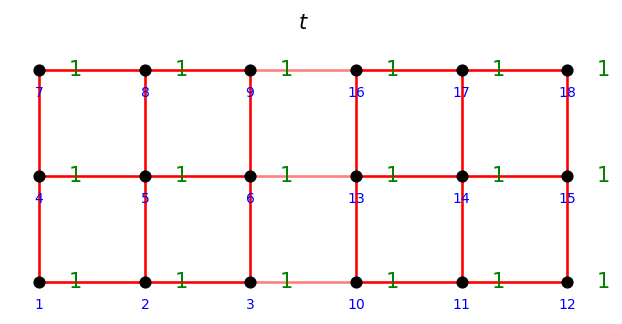

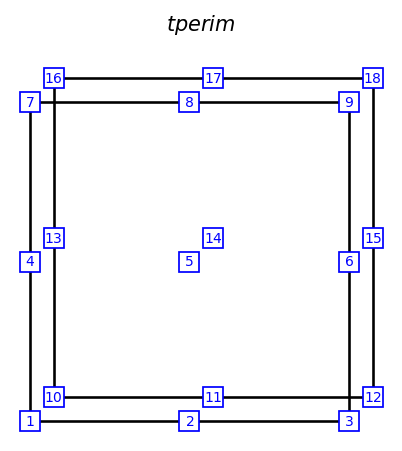

In [4]:
draw_operator('t')
draw_cluster_operator('clus', 'tperim')

In [5]:
# Setting target sectors with S=1 and S=-1 such that S_total = 0
set_target_sectors(['R0:N9:S-1', 'R0:N9:S1']) # half filling for both clusters
set_parameters("""
t = 1
U = 8
mu = 0.5*U
M = 0
M_1 = 0.1
M_2 = 1*M_1
t_1 = 1
t_2 = 1*t_1
tperim_1 = 1e-9
tperim_2 = 1*tperim_1
""")

[('t', 1.0),
 ('U', 8.0),
 ('mu', 0.5, 'U'),
 ('M', 0.0),
 ('M_1', 0.1),
 ('M_2', 1.0, 'M_1'),
 ('t_1', 1.0),
 ('t_2', 1.0, 't_1'),
 ('tperim_1', 1e-09),
 ('tperim_2', 1.0, 'tperim_1')]

#### Estimating the starting value of `M_1` 
Here we make a rough plot of the self-energy functional as a function of `M_1` to find a good starting point for the VCA procedure.

In [6]:
set_parameter("U", 10)
new_model_instance()

plot_sef("M_1", np.arange(0.05, 0.151, 0.01))

#### Controlled VCA loop over $U$
Here we loop over $U$ in the range from 10 to 0 and perform the VCA with `M_1` as a variational parameter. Looping downwards over U allows for easier convergence on a solution since no
We use the function `controlled_loop()` to benefit from predictors.

In [7]:
set_parameter("M_1", 0.11) # initial guess for M_1 based on the sef
new_model_instance()

def run_vca():
    vca(names=["M_1"], steps=[0.005], accur=[2e-3], max=[10])

# controlled_loop performs successive VCAs with starting value prediction
controlled_loop(run_vca, varia=["M_1"], loop_param="U", loop_range=(10, -0.1, -0.5)) # loops from 10 to 0 in increments of 0.5


%%%%%%%%%%%%%%%%%%%%%%%%%%%% controlled loop over U %%%%%%%%%%%%%%%%%%%%%%%%%%%%


========================= loop index = 1, U = 10.0000 =========================

******************************** VCA procedure ********************************
M_1       =  0.1100	
x =  [ 0.11]
x =  [ 0.115]
x =  [ 0.105]
QN iteration no  1 	 x =  [ 0.106721]
x =  [ 0.106721]
x =  [ 0.110721]
x =  [ 0.102721]
QN iteration no  2 	 x =  [ 0.106819]
convergence on position after  2  iterations
x =  [ 0.106819]
saddle point =  [ 0.106819]
gradient =  [-0.000084]
second derivatives : [ 0.85314]
computing properties of converged solution...
omega =  -5.415454367572838
****************************** VCA ended normally ******************************
predictor :  [ 0.106819] 
 --->  M_1  =  0.10681930163837199

========================== loop index = 2, U = 9.5000 ==========================

******************************** VCA procedure ********************************
M_1       =  0.1068	
x =  [ 0.106819]
x =

#### VCA for $U=8$ with `M_1` and `t_1` as variational parameters

In [6]:
set_parameter("U", 8)
new_model_instance()

vca(names=["M_1", "t_1"], start=[0.17, 1.15], steps=[0.005, 0.005], accur=[2e-3, 2e-3], max=[10, 10]) # Performing

******************************** VCA procedure ********************************
M_1       =  0.1700	t_1       =  1.1500	
x =  [ 0.17  1.15]
x =  [ 0.175  1.15 ]
x =  [ 0.165  1.15 ]
x =  [ 0.17   1.155]
x =  [ 0.17   1.145]
QN iteration no  1 	 x =  [ 0.169733  1.154732]
x =  [ 0.169733  1.154732]
x =  [ 0.173733  1.154732]
x =  [ 0.165733  1.154732]
x =  [ 0.169733  1.159464]
x =  [ 0.169733  1.15    ]
QN iteration no  2 	 x =  [ 0.170523  1.155074]
convergence on position after  2  iterations
x =  [ 0.170523  1.155074]
saddle point =  [ 0.170523  1.155074]
gradient =  [-0.000733  0.000042]
second derivatives : [ 0.88814   0.149027]
computing properties of converged solution...
omega =  -4.505013137870616
****************************** VCA ended normally ******************************


(array([ 0.170523,  1.155074]), array([ 0.88814 ,  0.149027]))

#### VCA for $U=8$ with `M_1`, `t_1` and `tperim_1` as variational parameters

In [7]:
set_parameter("U", 8)
new_model_instance()

vca(names=["M_1", "t_1", "tperim_1"], start=[0.17, 1.15, 0.04], steps=[0.005, 0.005, 0.005], accur=[2e-3, 2e-3, 2e-3], max=[10, 10, 10])

******************************** VCA procedure ********************************
M_1       =  0.1700	t_1       =  1.1500	tperim_1  =  0.0400	
x =  [ 0.17  1.15  0.04]
x =  [ 0.175  1.15   0.04 ]
x =  [ 0.165  1.15   0.04 ]
x =  [ 0.17   1.155  0.04 ]
x =  [ 0.17   1.145  0.04 ]
x =  [ 0.17   1.15   0.045]
x =  [ 0.17   1.15   0.035]
QN iteration no  1 	 x =  [ 0.183859  1.122018 -0.010895]
x =  [ 0.183859  1.122018 -0.010895]
x =  [ 0.197718  1.122018 -0.010895]
x =  [ 0.17      1.122018 -0.010895]
x =  [ 0.183859  1.15     -0.010895]
x =  [ 0.183859  1.094037 -0.010895]
x =  [ 0.183859  1.122018  0.04    ]
x =  [ 0.183859  1.122018 -0.061789]
QN iteration no  2 	 x =  [ 0.174535  1.137704  0.012157]
x =  [ 0.174535  1.137704  0.012157]
x =  [ 0.183859  1.137704  0.012157]
x =  [ 0.165212  1.137704  0.012157]
x =  [ 0.174535  1.15339   0.012157]
x =  [ 0.174535  1.122018  0.012157]
x =  [ 0.174535  1.137704  0.035209]
x =  [ 0.174535  1.137704 -0.010895]
QN iteration no  3 	 x =  [ 0.17

(array([ 0.172618,  1.139356,  0.010419]),
 array([ 0.999709,  0.697986,  0.407349]))

In [8]:
# Getting data from prerun VCAs
d_M = np.genfromtxt("./example_data/EX2_data_M.tsv", names=True)
d_M_t = np.genfromtxt("./example_data/EX2_data_M_t.tsv", names=True)
d_M_t_tperim = np.genfromtxt("./example_data/EX2_data_M_t_tperim.tsv", names=True)


#### Plotting $|\langle M \rangle|$ as a function of $U$ for all three simulations

/tmp/ipykernel_901/2684501046.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


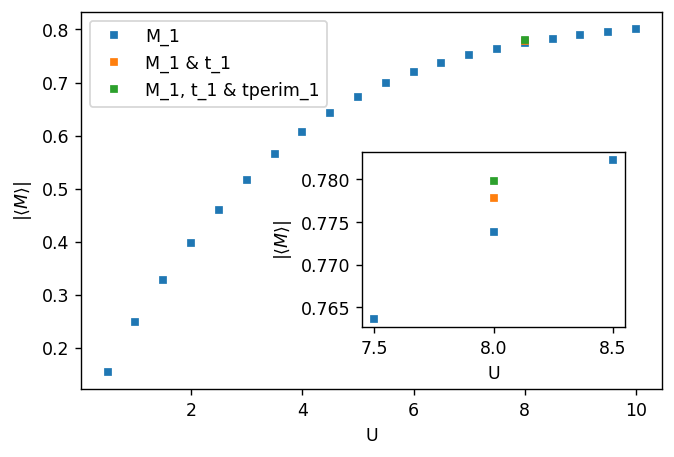

In [12]:
fig, ax = plt.subplots()

ax.plot(d_M["U"], np.abs(d_M["ave_M"]), "s", markersize=3, label="M_1")
ax.plot(d_M_t["U"], np.abs(d_M_t["ave_M"]), "s", markersize=3, label="M_1 & t_1")
ax.plot(d_M_t_tperim["U"], np.abs(d_M_t_tperim["ave_M"]), "s", markersize=3, label="M_1, t_1 & tperim_1")

ax.legend(loc="upper left")

ax.set_xlabel("U")
ax.set_ylabel("$|\langle M\\rangle|$")

subax = fig.add_axes([0.5, 0.25, 0.35, 0.35])

subax.plot(d_M["U"][14:17], np.abs(d_M["ave_M"][14:17]), "s", markersize=3)
subax.plot(d_M_t["U"], np.abs(d_M_t["ave_M"]), "s", markersize=3)
subax.plot(d_M_t_tperim["U"], np.abs(d_M_t_tperim["ave_M"]), "s", markersize=3)

subax.set_xlabel("U")
subax.set_ylabel("$|\langle M\\rangle|$")

subax.set_xticks((d_M["U"][14:17]))

fig.show()

#### Plotting the Weiss field as a function of $U$ for all three simulations

/tmp/ipykernel_901/765463404.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


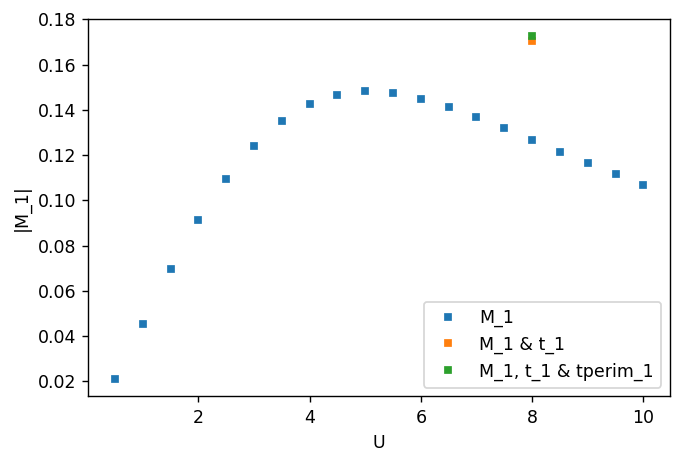

In [14]:
fig, ax = plt.subplots()

ax.plot(d_M["U"], d_M["M_1"], "s", markersize=3, label="M_1")
ax.plot(d_M_t["U"], d_M_t["M_1"], "s", markersize=3, label="M_1 & t_1")
ax.plot(d_M_t_tperim["U"], d_M_t_tperim["M_1"], "s", markersize=3, label="M_1, t_1 & tperim_1")

ax.legend(loc="lower right")

ax.set_xlabel("U")
ax.set_ylabel("|M_1|")

fig.show()

### Interpretation

In the first figure, we can see how $|\langle M \rangle|$ seems to approach 1 relatively quickly as a function of $U$. On the other hand, $|M\_1|$ seems to peak around $U\approx 5$ (fig.2). This means that as $U$ rises above 5, a rise in order parameter actually requires a *diminishing* Weiss field due to the rising interaction strength.

In both figures, adding in t_1 to the variational parameters seems to cause a rise in the values. However, adding in tperim_1 only causes a very minute increase. This makes sense since there doesn't seem to be a good reason for hopping exclusively around the perimeter of the cluster as described in the definition of the given operator.